# CARGA DE LIBRERÍAS y DATOS

The loading of libraries and the data necessary to carry out the analysis and the creation of the machine learning model to predict the probability of purchase of the leads is carried out.

In [1]:
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import uuid
from datetime import datetime
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import AddMissingIndicator, \
    CategoricalImputer, MeanMedianImputer
from feature_engine.transformation import LogCpTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, \
    recall_score

In [2]:
leads = pd.read_csv("./data/leads.csv")
offers = pd.read_csv("./data/offers.csv")

# PREPROCESAMIENTO DE LOS DATOS

In [3]:
def f(row):
   if row['Status'] == 'Closed Won':
       val = 1
   elif row['Status'] == 'Closed Lost':
       val = 0
   else:
       val = -1
   return val

offers['status_num'] = offers.apply(f, axis=1)

In [4]:
df_grouped = offers.groupby('Id')

# Encuentra el índice del valor máximo en 'columna_interes' para cada grupo
idx_max = df_grouped['status_num'].idxmax()

# Selecciona las filas correspondientes en el dataframe
df_max = offers.loc[idx_max]

offers_final = df_max[['Id','Status','status_num']]

In [5]:
dataframe_final = pd.merge(left=leads,right=offers_final, how='left', on='Id')

In [6]:
dataframe_final = dataframe_final[dataframe_final['status_num'] != -1]
dataframe_final = dataframe_final[dataframe_final['Id'].isna()==False]
dataframe_final = dataframe_final[~ ((dataframe_final['status_num'].isna()) & (dataframe_final['Converted']==1))]

In [7]:
dataframe_final.loc[(dataframe_final['status_num'].isna()) & (dataframe_final['Converted']==0),['status_num']] = 0

In [8]:
dataframe_final.isna().sum()

Id                                0
First Name                     4222
Use Case                      11496
Source                           28
Status_x                          0
Discarded/Nurturing Reason     9224
Acquisition Campaign          25998
Created Date                      0
Converted                         0
City                          13611
Status_y                      39986
status_num                        0
dtype: int64

In [9]:
dataframe_final= dataframe_final.rename(columns={'status_num':'purchased'})
dataframe_final= dataframe_final.rename(columns={'Status_x':'status_lead'})

In [10]:
dataframe_final['Created Date']=pd.to_datetime(dataframe_final['Created Date'])

In [11]:
dataframe_final['day_of_week'] = dataframe_final['Created Date'].dt.dayofweek
dataframe_final['day_of_month'] = dataframe_final['Created Date'].dt.day
dataframe_final['month'] = dataframe_final['Created Date'].dt.month

In [12]:
list_category_columns = ['purchased','Use Case','Source','status_lead','Discarded/Nurturing Reason',
                         'Acquisition Campaign','City','day_of_week','day_of_month','month']

dataframe_final[list_category_columns] = dataframe_final[list_category_columns].astype('category')

In [13]:
dataframe_final = dataframe_final.drop(columns=['First Name','Created Date','Converted','Status_y'])

In [14]:
dataframe_final = dataframe_final.set_index('Id')

# ESTADÍSTICAS DESCRIPTIVAS

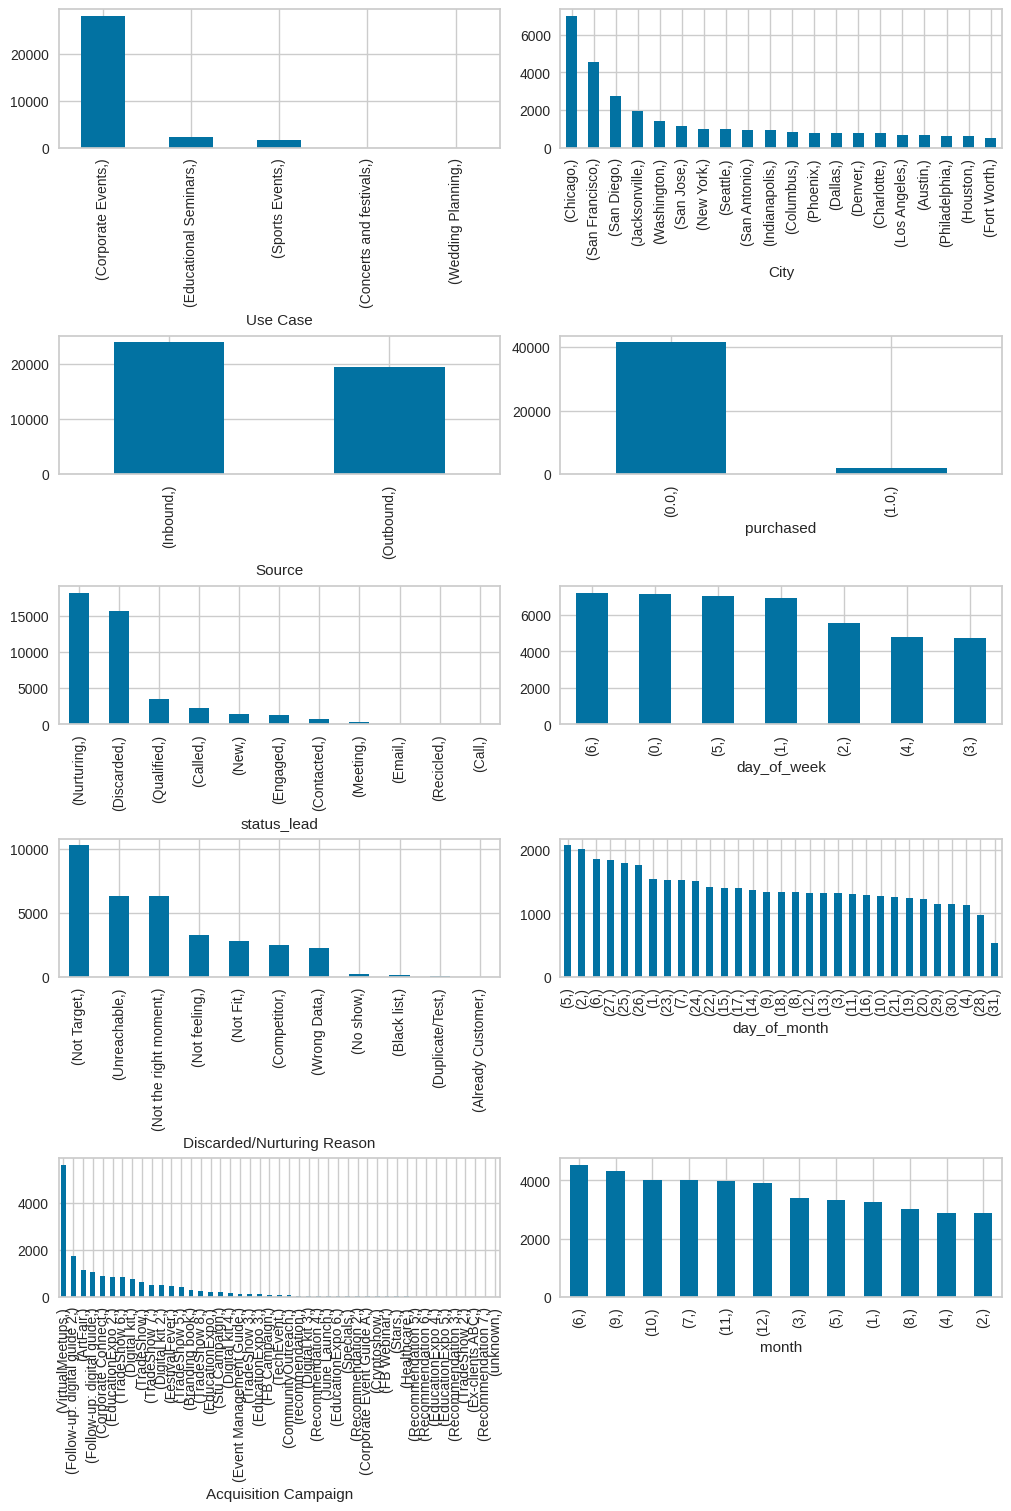

In [15]:
ncols = 2
nrows = len(dataframe_final.columns) // ncols

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True,figsize=(10,15
                                                                       ))
for col, ax in zip(dataframe_final.columns, axs.T.ravel()):
    dataframe_final[[col]].value_counts().plot.bar(ax=ax)

In [16]:
dataframe_final.columns.drop('purchased')

Index(['Use Case', 'Source', 'status_lead', 'Discarded/Nurturing Reason',
       'Acquisition Campaign', 'City', 'day_of_week', 'day_of_month', 'month'],
      dtype='object')

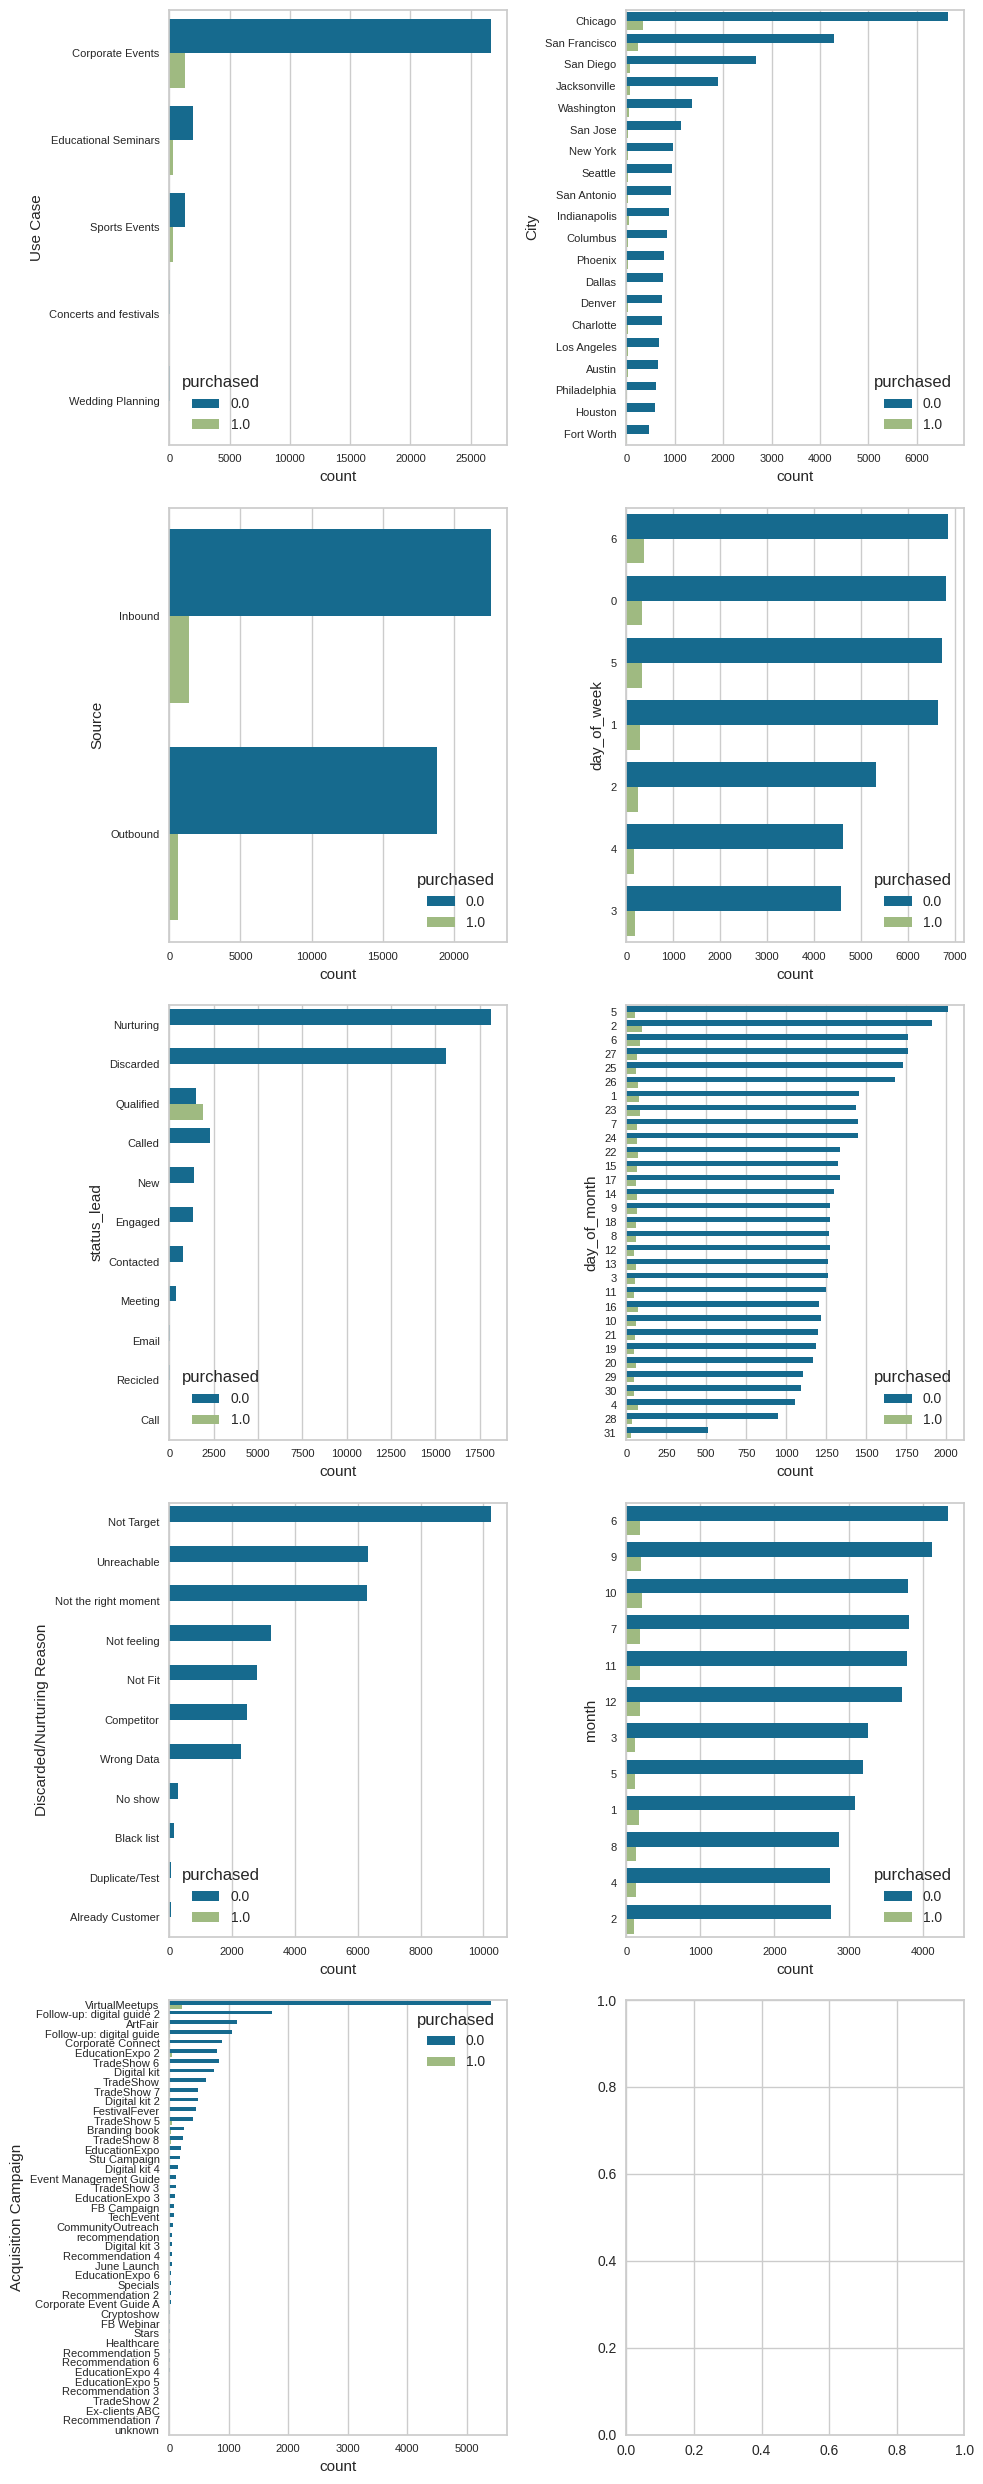

In [17]:
ncols = 2
nrows = len(dataframe_final.columns) // ncols

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True,figsize=(10,25))

for col, ax in zip(dataframe_final.columns.drop('purchased'), axs.T.ravel()):
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    # ax.set_xlabel("sepal_length", fontsize=40)
    ax.tick_params(labelsize=8)
    sns.countplot(y=col, data=dataframe_final, hue="purchased", ax=ax,
                  order=dataframe_final[col].value_counts(ascending=False).index)
    
    # sns.barplot(dataframe_final, x=col, y=col, hue="purchased")
    # dataframe_final[[col]].value_counts().plot.bar(ax=ax)
    
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

# FEATURE SELECTION AND FEATURE ENGINEERING

In [18]:
# import os
# os.add_dll_directory("C://Users/karol/Anaconda3/DLLs")

In [19]:
dataframe_final = dataframe_final.drop(columns=['status_lead','Discarded/Nurturing Reason'])

In [20]:
categorical = dataframe_final.drop(columns='purchased').select_dtypes(include=["category","object"]).columns

cat_vars_with_na = [
    var for var in categorical
    if dataframe_final.drop(columns='purchased')[var].isnull().sum() > 0
]
with_string_missing = [
    var for var in cat_vars_with_na if dataframe_final.drop(columns='purchased')[var].isnull().mean() > 0.1]
with_frequent_category = [
    var for var in cat_vars_with_na if dataframe_final.drop(columns='purchased')[var].isnull().mean() < 0.1]

if len(with_string_missing) > 0:
    cat_imp_miss=CategoricalImputer(
        imputation_method='missing', variables=with_string_missing)

if len(with_frequent_category) > 0:
     cat_imp_freq=CategoricalImputer(
        imputation_method='frequent', variables=with_frequent_category)

In [21]:
dataframe_final[with_string_missing] = cat_imp_miss.fit_transform(dataframe_final[with_string_missing])
dataframe_final[with_frequent_category] = cat_imp_freq.fit_transform(dataframe_final[with_frequent_category])

In [22]:
# Assuming X_train is your input features dataframe and it includes categorical data
encoder = OneHotEncoder()

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(dataframe_final.drop(columns='purchased')[categorical])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,  # predictive variables
    dataframe_final['purchased'],  # target
    test_size=0.2,  # portion of dataset to allocate to test set
    random_state=0,  # we are setting the seed here
)

In [24]:
sel_ = SelectFromModel(
        LogisticRegression(C= 0.5,
                        penalty='l1',
                        solver='liblinear',
                        random_state=10))


    # remove features with zero coefficient from dataset
    # and parse again as dataframe
sel_.fit(X_train, y_train)
importance = sel_.estimator_.coef_[0]

X_train_new = pd.DataFrame(sel_.transform(X_train),
                columns = X_train.columns[(sel_.get_support())],
                index = X_train.index)       

# PIPELINE

In [25]:
train_new = pd.concat([X_train_new,y_train], axis=1)
test_new = pd.concat([X_test[X_train_new.columns],y_test], axis=1)

In [26]:
test_new

,Use Case_Corporate Events,Use Case_Missing,Use Case_Educational Seminars,Use Case_Sports Events,Use Case_Concerts and festivals,Source_Outbound,Acquisition Campaign_Missing,Acquisition Campaign_Follow-up: digital guide 2,Acquisition Campaign_Event Management Guide,Acquisition Campaign_VirtualMeetups,...,month_3,month_1,month_4,month_2,month_6,month_7,month_8,month_11,month_12,purchased
Id,,,,,,,,,,,,,,,,,,,,,
cturqi48,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
wxuffik9,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0.0
9pqsgn1r,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
48l6ksr9,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.0
ho8fygz3,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
orb1bigh,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
fwezz4xw,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
a6kf24of,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.0


In [27]:
# Entrenamiento

setup_model1 = setup(data = train_new, target = 'purchased',
            session_id = 1, 
            preprocess = False,
            test_data = test_new,
            index=True,
            verbose = True
                    )

best = compare_models(sort = 'AUC', cross_validation=True, fold=5, turbo=True)


,Description,Value
0,Session id,1
1,Target,purchased
2,Target type,Binary
3,Original data shape,"(43441, 81)"
4,Transformed data shape,"(43441, 81)"
5,Transformed train set shape,"(34752, 81)"
6,Transformed test set shape,"(8689, 81)"
7,Numeric features,80


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9552,0.7850,0.0013,0.1400,0.0026,0.0017,0.0089,0.7740
lightgbm,Light Gradient Boosting Machine,0.9552,0.7813,0.0000,0.0000,0.0000,-0.0007,-0.0039,186.2220
lr,Logistic Regression,0.9555,0.7780,0.0000,0.0000,0.0000,0.0000,0.0000,0.6440
ada,Ada Boost Classifier,0.9555,0.7759,0.0000,0.0000,0.0000,-0.0001,-0.0005,0.3260
lda,Linear Discriminant Analysis,0.9469,0.7697,0.0692,0.2245,0.1032,0.0833,0.1000,0.2600
nb,Naive Bayes,0.4407,0.7373,0.9366,0.0697,0.1297,0.0511,0.1490,0.3660
qda,Quadratic Discriminant Analysis,0.2957,0.7215,0.9651,0.0576,0.1088,0.0271,0.1089,0.2960
rf,Random Forest Classifier,0.9476,0.6919,0.0239,0.1083,0.0391,0.0232,0.0306,0.4400
et,Extra Trees Classifier,0.9458,0.6480,0.0343,0.1209,0.0533,0.0342,0.0417,0.6320
knn,K Neighbors Classifier,0.9538,0.5936,0.0084,0.1475,0.0158,0.0113,0.0250,5.3600


In [28]:
test_new = test_new.rename(columns = {'Acquisition Campaign_Follow-up: digital guide':'Acquisition Campaign_Follow-up digital guide',
                           'Acquisition Campaign_Follow-up: digital guide 2':'Acquisition Campaign_Follow-up digital guide 2'})

In [52]:
sel_.feature_names_in_

AttributeError: 'SelectFromModel' object has no attribute 'feature_names_'

{'f1': 0.4147858058564131,
 'precision': 0.5339468922132755,
 'recall': 0.696505535639359,
 'roc_auc': 0.749307124927308,
 'optimal_threshold': 0.03699451268005686,
 'cm': array([[4337, 3959],
        [  51,  342]]),
 'actual': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

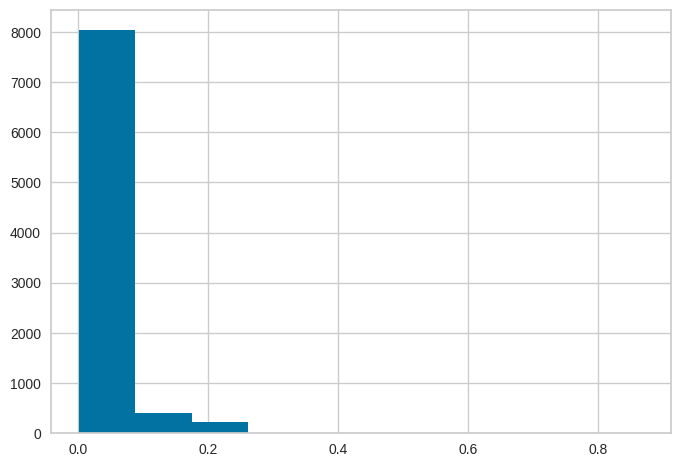

In [29]:

# Obtiene las probabilidades de la clase positiva
y_prob = best.predict_proba(test_new.drop(columns=['purchased']))[:,1 ]

# Calcula el ROC-AUC con diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_values = roc_auc_score(y_test, y_prob)

# Encuentra el umbral óptimo que maximiza el AUC
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

# Convierte las probabilidades en etiquetas binarias usando el umbral óptimo
y_pred = (y_prob >= optimal_threshold).astype(int)

f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')

# Calculate Precision and Recall
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')

labels = y_test.unique().tolist()
cm = confusion_matrix(y_test, y_pred)
test_new['prob'] = y_prob
test_new['prob'].hist()
report = {
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc_values,
    'optimal_threshold': optimal_threshold,
    'cm': cm,
    'actual': y_test.tolist(),
    'predicted': y_pred.tolist()
}

report

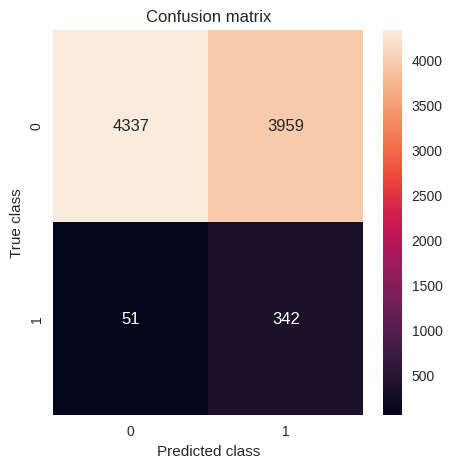

In [30]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# TÉCNICAS DE REMUESTREO

## UNDERSAMPLING

In [31]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy=0.5)
X_train_under, y_train_under = under.fit_resample(X_train_new, y_train)


In [32]:
test_new = pd.concat([X_test[X_train_new.columns],y_test], axis=1)

In [33]:
# Entrenamiento

setup_model2 = setup(data = pd.concat([X_train_under, y_train_under], axis=1), target = 'purchased',
            session_id = 1, 
            preprocess = False,
            test_data = test_new,
            index=True,
            verbose = True
                    )

best1 = compare_models(sort = 'AUC', cross_validation=True, fold=5, turbo=True)

,Description,Value
0,Session id,1
1,Target,purchased
2,Target type,Binary
3,Original data shape,"(13327, 81)"
4,Transformed data shape,"(13327, 81)"
5,Transformed train set shape,"(4638, 81)"
6,Transformed test set shape,"(8689, 81)"
7,Numeric features,80


In [34]:
test_new = test_new.rename(columns = {'Acquisition Campaign_Follow-up: digital guide':'Acquisition Campaign_Follow-up digital guide',
                           'Acquisition Campaign_Follow-up: digital guide 2':'Acquisition Campaign_Follow-up digital guide 2'})

{'f1': 0.4147858058564131,
 'precision': 0.5339468922132755,
 'recall': 0.696505535639359,
 'roc_auc': 0.749307124927308,
 'optimal_threshold': 0.03699451268005686,
 'cm': array([[4337, 3959],
        [  51,  342]]),
 'actual': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

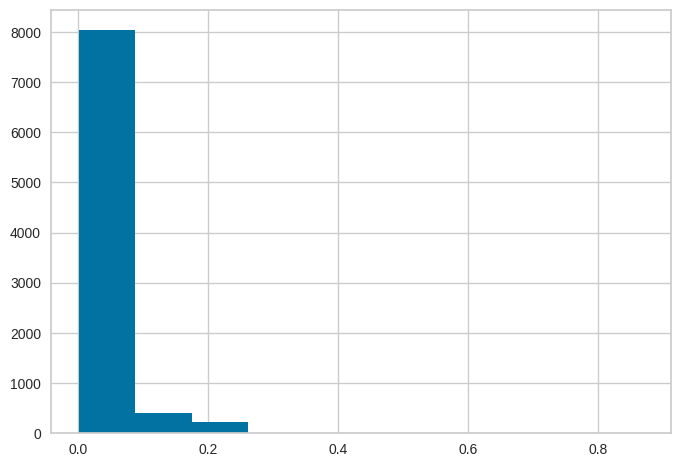

In [35]:

# Obtiene las probabilidades de la clase positiva
y_prob = best.predict_proba(test_new.drop(columns=['purchased']))[:,1 ]

# Calcula el ROC-AUC con diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_values = roc_auc_score(y_test, y_prob)

# Encuentra el umbral óptimo que maximiza el AUC
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

# Convierte las probabilidades en etiquetas binarias usando el umbral óptimo
y_pred = (y_prob >= optimal_threshold).astype(int)

f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')

# Calculate Precision and Recall
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')

labels = y_test.unique().tolist()
cm = confusion_matrix(y_test, y_pred)
test_new['prob1'] = y_prob
test_new['prob1'].hist()
report = {
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc_values,
    'optimal_threshold': optimal_threshold,
    'cm': cm,
    'actual': y_test.tolist(),
    'predicted': y_pred.tolist()
}

report

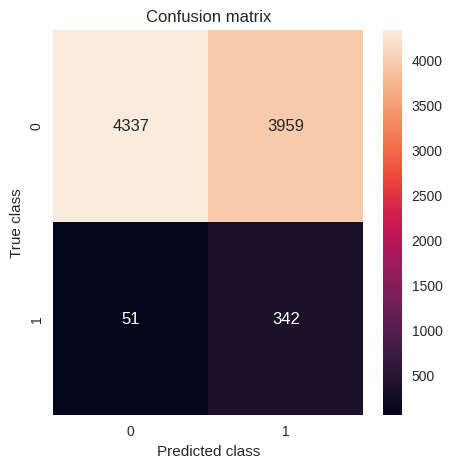

In [36]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## OVERSAMPLING

In [37]:
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(sampling_strategy=0.1)
X_train_over, y_train_over = over.fit_resample(X_train_new, y_train)

In [38]:
test_new = pd.concat([X_test[X_train_new.columns],y_test], axis=1)

In [39]:
# Entrenamiento

setup_model3 = setup(data = pd.concat([X_train_over, y_train_over], axis=1), target = 'purchased',
            session_id = 1, 
            preprocess = False,
            test_data = test_new,
            index=True,
            verbose = True
                    )

best3 = compare_models(sort = 'AUC', cross_validation=True, fold=5, turbo=True)

,Description,Value
0,Session id,1
1,Target,purchased
2,Target type,Binary
3,Original data shape,"(45215, 81)"
4,Transformed data shape,"(45215, 81)"
5,Transformed train set shape,"(36526, 81)"
6,Transformed test set shape,"(8689, 81)"
7,Numeric features,80


In [40]:
test_new = test_new.rename(columns = {'Acquisition Campaign_Follow-up: digital guide':'Acquisition Campaign_Follow-up digital guide',
                           'Acquisition Campaign_Follow-up: digital guide 2':'Acquisition Campaign_Follow-up digital guide 2'})

In [42]:

# Obtiene las probabilidades de la clase positiva
y_prob = best3.predict_proba(test_new.drop(columns=['purchased']))[:,1 ]

# Calcula el ROC-AUC con diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_values = roc_auc_score(y_test, y_prob)

# Encuentra el umbral óptimo que maximiza el AUC
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

# Convierte las probabilidades en etiquetas binarias usando el umbral óptimo
y_pred = (y_prob >= optimal_threshold).astype(int)

f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')

# Calculate Precision and Recall
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')

labels = y_test.unique().tolist()
cm = confusion_matrix(y_test, y_pred)
test_new['prob2'] = y_prob
test_new['prob2'].hist()
report = {
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc_values,
    'optimal_threshold': optimal_threshold,
    'cm': cm,
    'actual': y_test.tolist(),
    'predicted': y_pred.tolist()
}

report

AttributeError: 'list' object has no attribute 'predict_proba'

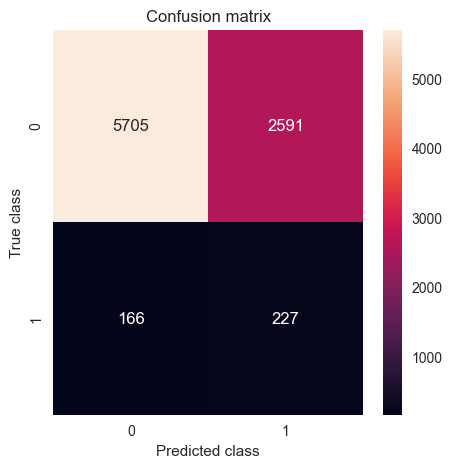

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## SMOTETOMEK

In [ ]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek()
X_train_smote, y_train_smote = smote.fit_resample(X_train_new, y_train)

In [ ]:
test_new = pd.concat([X_test[X_train_new.columns],y_test], axis=1)

In [ ]:
# Entrenamiento

setup_model4 = setup(data = pd.concat([X_train_smote, y_train_smote], axis=1), target = 'purchased',
            session_id = 1, 
            preprocess = False,
            test_data = test_new,
            index=True,
            verbose = True
                    )

best4 = compare_models(sort = 'AUC', cross_validation=True, fold=5, turbo=True)

,Description,Value
0,Session id,1
1,Target,purchased
2,Target type,Binary
3,Original data shape,"(74955, 81)"
4,Transformed data shape,"(74955, 81)"
5,Transformed train set shape,"(66266, 81)"
6,Transformed test set shape,"(8689, 81)"
7,Numeric features,80


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9252,0.9736,0.9635,0.8948,0.9275,0.8504,0.8537,2.3440
et,Extra Trees Classifier,0.9280,0.9681,0.9592,0.9029,0.9297,0.8561,0.8587,2.2020
lightgbm,Light Gradient Boosting Machine,0.8931,0.9538,0.9284,0.8671,0.8960,0.7861,0.7895,0.2800
dt,Decision Tree Classifier,0.9196,0.9474,0.9600,0.8880,0.9222,0.8391,0.8428,0.2820
lr,Logistic Regression,0.8648,0.9369,0.8850,0.8504,0.8664,0.7295,0.7317,0.5460
lda,Linear Discriminant Analysis,0.8596,0.9327,0.8852,0.8417,0.8621,0.7191,0.7215,0.5700
ada,Ada Boost Classifier,0.8233,0.9005,0.8847,0.7880,0.8332,0.6467,0.6524,1.1020
gbc,Gradient Boosting Classifier,0.8032,0.8960,0.8830,0.7614,0.8176,0.6063,0.6145,1.9880
nb,Naive Bayes,0.7443,0.8051,0.9545,0.6720,0.7887,0.4886,0.5385,0.1320
qda,Quadratic Discriminant Analysis,0.7253,0.7644,0.9762,0.6521,0.7813,0.4506,0.5197,0.4480


In [ ]:
test_new = test_new.rename(columns = {'Acquisition Campaign_Follow-up: digital guide':'Acquisition Campaign_Follow-up digital guide',
                           'Acquisition Campaign_Follow-up: digital guide 2':'Acquisition Campaign_Follow-up digital guide 2'})

{'f1': 0.4537482113490045,
 'precision': 0.5258847401178959,
 'recall': 0.6408384371143026,
 'roc_auc': 0.6601874105918177,
 'optimal_threshold': 0.03544523246650906,
 'cm': array([[5271, 3025],
        [ 139,  254]], dtype=int64),
 'actual': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  

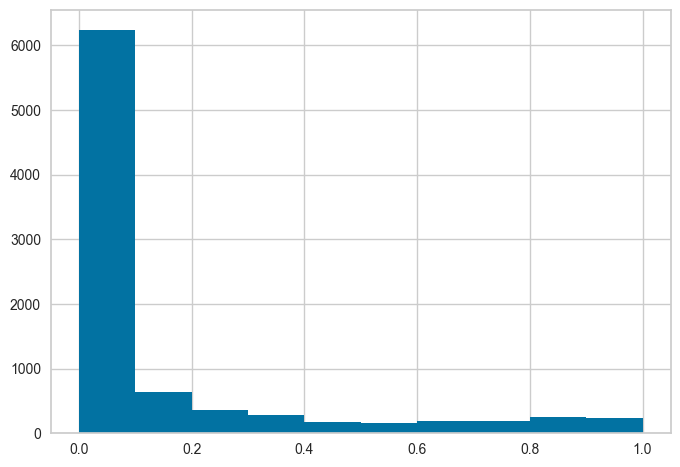

In [ ]:
# Obtiene las probabilidades de la clase positiva
y_prob = best4.predict_proba(test_new.drop(columns=['purchased']))[:,1 ]

# Calcula el ROC-AUC con diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_values = roc_auc_score(y_test, y_prob)

# Encuentra el umbral óptimo que maximiza el AUC
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

# Convierte las probabilidades en etiquetas binarias usando el umbral óptimo
y_pred = (y_prob >= optimal_threshold).astype(int)

f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')

# Calculate Precision and Recall
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')

labels = y_test.unique().tolist()
cm = confusion_matrix(y_test, y_pred)
test_new['prob3'] = y_prob
test_new['prob3'].hist()
report = {
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc_values,
    'optimal_threshold': optimal_threshold,
    'cm': cm,
    'actual': y_test.tolist(),
    'predicted': y_pred.tolist()
}

report

In [ ]:

# Obtiene las probabilidades de la clase positiva
y_prob = pipeline_fit.predict_proba(X_motos_test)[:, 1]

# Calcula el ROC-AUC con diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_motos_test, y_prob)
roc_auc_values = roc_auc_score(y_motos_test, y_prob)

# Encuentra el umbral óptimo que maximiza el AUC
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

# Convierte las probabilidades en etiquetas binarias usando el umbral óptimo
y_pred = (y_prob >= optimal_threshold).astype(int)

f1 = f1_score(y_true=y_motos_test, y_pred=y_pred, average='macro')

# Calculate Precision and Recall
precision = precision_score(y_true=y_motos_test, y_pred=y_pred, average='macro')
recall = recall_score(y_true=y_motos_test, y_pred=y_pred, average='macro')

labels = y_motos_test.unique().tolist()
cm = confusion_matrix(y_motos_test, y_pred)
X_motos_test['prob'] = y_prob
X_motos_test['prob'].hist()
model_name = pipeline[-1]._class.name_
report = {
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc_values,
    'optimal_threshold': optimal_threshold,
    'cm': cm,
    'actual': y_motos_test.tolist(),
    'predicted': y_pred.tolist(),
    'model_name': model_name
}

report

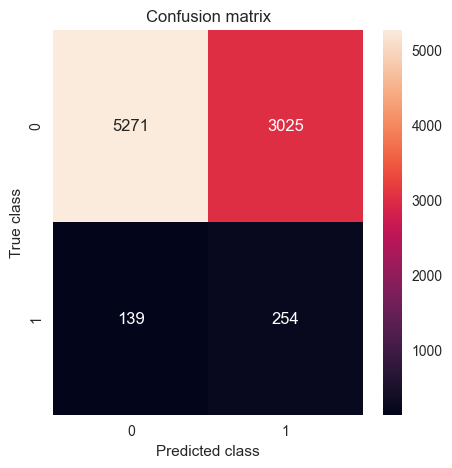

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()